# Proyecto Final Algebra Lineal 2017
---

El proyecto del curso consiste en la implementación del [Algortimo de Canny](https://es.wikipedia.org/wiki/Algoritmo_de_Canny) para la detección de bordes en imágenes y videos. Para ello, se le entrega al estudiante toda la implementación del algoritmo en [OpenCV](http://opencv.org/) y su objetivo es **implementar las funciones de OpenCV con matrices**. 

Las funciones a modificar serán las siguientes:
```python
cv2.GaussianBlur()
cv2.Sobel()
```

No es necesario que modifique más del código que se le solicita, pero puede hacer las modificaciones pertinentes si ese fuera el caso. Dentro del código se le indica en qué parte debe de ser modificado, por ejemplo:

```python
'''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
``` 

Se recomienda buscar maneras de optimizar los cálculos de sus filtros, pues más adelante existe una aplicación en tiempo real donde es crucial que sus cálculos sean lo más rápidos posibles. Las dimensiones de los *kernels* no pueden ser modificadas.

## 0. Conceptos
Para poder modificar las funciones solicitadas es necesario que comprenda algunos conceptos, por lo cual es necesario que defina:

#### 1. ¿En que consiste la convolución y cómo puede ser calculada? (Puede dar una definición matemática y/o ejemplos).

¿Qué es una convolución? - Una convolución es una función, que de forma lineal y continua, transforma una señal de entrada en una nueva señal de salida.

¿En que consiste?
Consiste en dos funciones de entrada y un función de salida como resultado.

¿Comó puede ser calculada?
La convolución puede ser aplicada a dos funciones cualesquiera de tiempo o espacio (u otras variables) para arrojar una tercera función, la salida de la convolución

En un sistema unidimensional, se dice que g(x) convoluciona f(x) cuando:

        f(x)*g(x) = Integral{f(x')*g(x-x')}dx'    
       
donde x’ es una variable de integración.

El resultado de g(x) depende únicamente del valor de f(x) en el punto x, pero no de la posición de x. Es la propiedad que se denomina invariante respecto la posición (position-invariant) y es condición necesaria en la definición de las integrales de convolución.

En un sistema discreto, como el de las imágenes digitalizadas, la convolución de la función f(x,y) por g(x,y), en la que g(x,y) es una matriz de M filas por N columnas, es:

        f(x,y)*g(x,y) = Sumatoria( f(m,n)*g(x-m, y-n)) donde empieza en m = 0 y n = 0 hasta M-1 y N-1.
        
#### 2. ¿Qué es el *kernel* de un filtro y para que se utiliza?

El kernel es una matriz de números que son los coeficientes por los que debe multiplicarse los valores de intensidad del entorno de cada punto.

Se utiliza para hacer la transformación de los valores de intensidad, los valores del kernel varian segun el resultado que se desea obtener, existen kernel ya definidos o se pueden escribir los propios.

#### 3. ¿En qué consiste un filtro Gaussiano?

Simulan una distribución gaussiana bivariante. El valor máximo aparece en el pixel central y disminuye hacia los extremos tanto más rápido cuanto menor sea el parámetro dedesviación típica "s". El resultado será un conjunto de valores entre 0 y 1. Para transformar la matriz a una matriz de números enteros se divide toda la matriz por el menor de los valores obtenidos. La
ecuación para calcularla es:


        g(x, y) = e− (x^2+y^2)/(2∗s2)

        G(x, y) = g(x, y)/{minx,y(g(x, y))}

#### 4. ¿En qué consiste el Filtro Sobel? ¿para qué sirve?

El filtro Sobel detecta los bordes horizontales y verticales separadamente sobre una imagen en escala de grises. Las imágenes en color se convierten en RGB en niveles de grises. Como con el filtro Laplace, el resultado es una imagen transparente con líneas negras y algunos restos de color.

El filtro Sobel realza la variación entre filas y columnas.

#### 5. Describa el algoritmo de detección de bordes Canny.

El algorito de Canny consiste en tres grandes pasos:
- Obtención del gradiente: en este paso se calcula la magnitud y orientación del vector gradiente en cada píxel.
- Supresión no máxima: en este paso se logra el adelgazamiento delancho de los bordes, obtenidos con el gradiente, hasta lograr   bordes de un píxel de ancho.
- Histéresis de umbral: en este paso se aplica una función de histéresis basada en dos umbrales; con este proceso se pretende     reducir la posibilidad de aparición de contornos falsos.

a. Obtención del gradiente 
    Primero se aplica un filtro gaussiano a la imagen original con el objetivo de suavizar la imagen y tratar de eliminar el         posible ruido existente. Sin embargo, se debe de tener cuidado de no realizar un suavizado excesivo, pues se podrían perder     detalles  de la imagen y provocar un pésimo resultado final. 
    Una  vez  que  se  suaviza  la  imagen,  para  cada  píxel  se  obtiene  la  magnitud  y  módulo (orientación) del               gradiente, obteniendo así dos imágenes. 
    
b. Supresión no máxima al resultado del gradiente
    Las dos imágenes generadas en el paso anterior sirven de entrada para generar una imagen con los  bordes  adelgazados.  El       procedimiento  es  el  siguiente:  se  consideran  cuatro  direcciones identificadas por las orientaciones de 0º, 45º, 90º y     135º con respecto al eje horizontal. Para cada píxel se encuentra la dirección que mejor se aproxime a la dirección del         ángulo de gradiente.  

c. Histéresis de umbral a la supresión no máxima
    El proceso consiste en tomar la  imagen  obtenida  del paso anterior, tomar la orientación de los puntos de  borde de la         imagen y tomar  dos umbrales, el primero más pequeño que el segundo. Para cada punto de la imagen se debe localizar el           siguiente punto de borde no  explorado que sea mayor al segundo umbral. A partir de  dicho  punto  seguir  las cadenas de       máximos locales conectados en ambas direcciones perpendiculares a la normal del borde siempre que sean mayo res al primer       umbral. Así se marcan todos los puntos explorados y se almacena la lista de todos los puntos en  el contorno conectado. Es       así  como en este paso  se logra eliminar las uniones  en forma de Y de los segmentos que confluyan en un punto.
    Frecuentemente, es común que un cuarto y último paso se realice en el algoritmo de Canny, este paso consiste  en  cerrar         los  contornos que  pudiesen haber quedado  abiertos  por  problemas de ruido.  




In [1]:
from PIL import Image
from time import time
import numpy as np
import matplotlib.pylab as plt
import cv2
import math

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Define the kernels for Gaussian filter

kernel_5 = np.array([[1, 4, 7, 4, 1],
                     [4, 16, 26, 16, 4],
                     [7, 26, 41, 26, 7],
                     [4, 16, 26, 16, 4],
                     [1, 4, 7, 4, 1]], dtype= np.float)

kernel_5 = kernel_5 / 273

kernel_3 = np.array([[1, 2, 1],
                     [2, 8, 2],
                     [1, 2, 1]],dtype=np.float)

kernel_3 = kernel_3 / 20


In [3]:
#Funcion Gauss 1.0

def gaussian_filter(img, kernel):
    
    #Elegir que matriz kernel utilizar
    if(kernel == 3):
        matrix_Kernel = kernel_3
 
    else:
        matrix_Kernel = kernel_5
    
    limite = int(kernel / 2)
    
    #Dimensiones de la imagen
    rows, columns = img.shape
    
    #Matriz que contendra los resultados de la convolución
    gauss = np.zeros((rows,columns), dtype=np.uint8)
    
    #Recorrido de la imagen y convolución de cada pixel
    for i in range(limite, rows - 1 - limite):
        for j in range(limite, columns - 1 - limite):
            suma = 0
            for k in range( -limite, limite):
                for l in range(-limite, limite):
                    suma = suma + (img[i + k, j + l] * matrix_Kernel[limite + k, limite + l])
                
            gauss[i, j] = int(suma)
        
    return gauss

In [4]:
#Función Gauss 2.0

def gaussian_filter_2(image, kernel = 5):
    
    #Obtiene las dimensiones de la imagen 
    h, w = image.shape
    
    #Convierte la matriz en un arreglo 1D
    temp = np.ravel(image)
    
    #Obtiene el tamaño del arreglo generado anteriormente
    l = temp.size
    
    #Maximos recorridos dentro del arreglo
    max_x = w - 2
    max_y = w * (h - 2)
    
    #Realiza el recorrido y la convolución del pixel
    y = w*2
    while(y < max_y):
        for x in range(2, max_x):
            temp[x + y] = (2 * temp[x + y - 2 - w - w] +
                           4 * temp[x + y - 1 - w - w] + 
                           5 * temp[x + y - w - w] +
                           4 * temp[x + y + 1 - w - w] +
                           2 * temp[x + y + 2 - w - w] +
                           4 * temp[x + y - 2 - w] +
                           9 * temp[x + y - 1 - w] +
                           12 * temp[x + y - w] + 
                           9 * temp[x + y + 1 - w] + 
                           4 * temp[x + y + 2 - w] + 
                           5 * temp[x + y - 2] + 
                           12 * temp[x + y - 1] + 
                           15 * temp[x + y] + 
                           12 * temp[x + y + 1] + 
                           5 * temp[x + y + 2] + 
                           4 * temp[x + y - 2 + w] + 
                           9 * temp[x + y - 1 + w] + 
                           12 * temp[x + y + w] + 
                           9 * temp[x + y + 1 + w] + 
                           4 * temp[x + y + 2 + w] + 
                           2 * temp[x + y - 2 + w + w] + 
                           4 * temp[x + y - 1 + w + w] + 
                           5 * temp[x + y + w + w] + 
                           4 * temp[x + y + 1 + w + w] + 
                           2 * temp[x + y + 2 + w + w]) / 159
        y = y + w

    # Convertir nuevamente la imagen con la convolución ya realizada
    i = 0
    j = 0

    for z in range(0, l):
    
        if(j == w):
            i = i + 1
            j = 0
    
        image[i, j] = temp[z]
        j = j + 1        
    
    return image

In [5]:
#Funcion Gauss 3.0

def reflect(m, x):
    
    if(x < 0):
        return -x - 1
    
    if(x >= m):
        return 2*m -x - 1
    
    return x

def gaussian_filter_3(image, kernel = 5):
    
    #Arreglo de coeficientes de sigma = 1
    conv = np.array([0.0545, 0.2442, 0.4026, 0.2442, 0.0545], dtype=np.float)
    
    #Obtener las dimenciones h = height w = width
    h, w = image.shape
    
    #Matrices que contendran las convuluciones
    im2 = np.zeros(shape=(h, w), dtype=np.uint8)
    im2 = np.array(im2)
    
    im3 = np.zeros(shape=(h, w), dtype=np.uint8)
    im3 = np.array(im3)
    
    #Sobre la dirección Y
    for i in range(0, h):
        for j in range(0, w):
            suma = 0
            for l in range(-2, 3):
                y1 = reflect(h, i - l)
                suma = suma + conv[l + 2] * image[y1, j]
            
            im2[i, j] = suma
            
    #Sobre la direción X
    for i in range(0, h):
        for j in range(0, w):
            suma = 0
            for l in range(-2, 3):
                x1 = reflect(w, j - l)
                suma = suma + conv[l + 2] * im2[i, x1]
            
            im3[i, j] = suma
                          
    return im3

In [6]:
#Funcion Sobel 1D

def my_sobel(image, x, y, ksize_sobel = 3):
    
    #Elige que matriz kernel utilizar
    if((x == 0 or x == 1) and (y == 0 or y == 1)):
        if(x == 1 and y == 0):
            convc = np.array([[-1],[-2],[1]])
            
            convr = np.array([-1, 0, 1])
        else:
            if(y == 1 and x == 0):
                convc = np.array([[-1],[0],[1]])
                
                convr = np.array([-1, -2, -1])
            else:
                return null
    else:
        return null
     
    #Obtener las dimenciones h = height w = width
    h,w = image.shape
    
    #Arreglos que contendran las convoluciones
    im2 = np.zeros(shape=(h, w), dtype=int)
    im2 = np.array(im2)
    
    im3 = np.zeros(shape=(h, w), dtype=int)
    im3 = np.array(im3)

    #Sobre el eje y
    for i in range(1, h - 2):
        for j in range(1, w - 2):
            im2[i, j] = (image[i - 1, j] * convc[0, 0] + image[i, j] * convc[1,0] + image[i + 1, j] * convc[2, 0])
            
    
    #Sobre el eje x
    for i in range(1, h - 2):
        for j in range(1, w - 2):
            im3[i-1, j-1] = (im2[i, j-1] * convr[0] + im2[i, j] * convr[1] + im2[i, j+1] * convr[2])
            
            if (im3[i, j] < 0):
                im3[i, j] = -im3[i,j]
    
    return im3

In [7]:
#Funcion Sobel 2D

def my_sobel2(image, x, y, ksize_sobel = 3):
    
    #Elige que matriz kernel utilizar
    if((x == 0 or x == 1) and (y == 0 or y == 1)):
        if(x == 1 and y == 0):
            conv = np.array([[-1, 0 , 1],[-2, 0, 2],[-1, 0, 1]])
        else:
            if(y == 1 and x == 0):
                conv = np.array([[-1, -2 , -1],[0, 0, 0],[1, 2, 1]])
            else:
                return null
    else:
        return null
    
    #Obtiene las dimensiones de la imagen h = height w = width
    w,h = image.shape
    
    #Matriz de Salida
    output = np.zeros(shape=(w, h), dtype=int)
    output = np.array(output)
    
    #Recorre la matriz y realiza las multiplicaciones
    #No es muy eficiente
    for i in range(1, w - 2):
        for j in range(1, h - 2):
            output[i-1, j-1] = (image[i - 1, j - 1] * conv[0, 0] + image[i - 1, j] * conv[0, 1] + image[i - 1, j + 1] * conv[0, 2] 
                                + image[i, j - 1] * conv[1, 0] + image[i, j] * conv[1, 1] + image[i, j + 1] * conv[1, 2] +
                                image[i + 1, j - 1] * conv[2, 0] + image[i + 1, j] * conv[2, 1] + image[i+ 1, j + 1] * conv[2, 2])
            if (output[i, j] < 0):
                output[i, j] = -output[i,j]

    
    return output


In [8]:
def gaussian_blur(img, kernel = 5):
    
    return gaussian_filter_3(img, kernel)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        x,y = 1,0
    elif orient == 'y':
        x,y = 0,1
        
    #sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
    sobel = my_sobel(img, x, y, sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Take the gradient in x and y separately

    #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = my_sobel(image, 1, 0, sobel_kernel)
    
    #sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = my_sobel(image, 0, 1, sobel_kernel)
    
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 +sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Take the gradient in x and y separately

    #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = my_sobel(image, 1, 0, sobel_kernel)
    
    #sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = my_sobel(image, 0, 1, sobel_kernel)

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return sbinary

## 1. Prueba en Imagen

In [9]:
# Test filter on single image
#im = plt.imread("lena_gray.png")
im = np.array(Image.open("BTD6.jpg"))
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Gaussian Blur Filtering

gray = gaussian_blur(gray, kernel = 5)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Create combined image with sobel filters applied
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)


## 2. Prueba en Videos

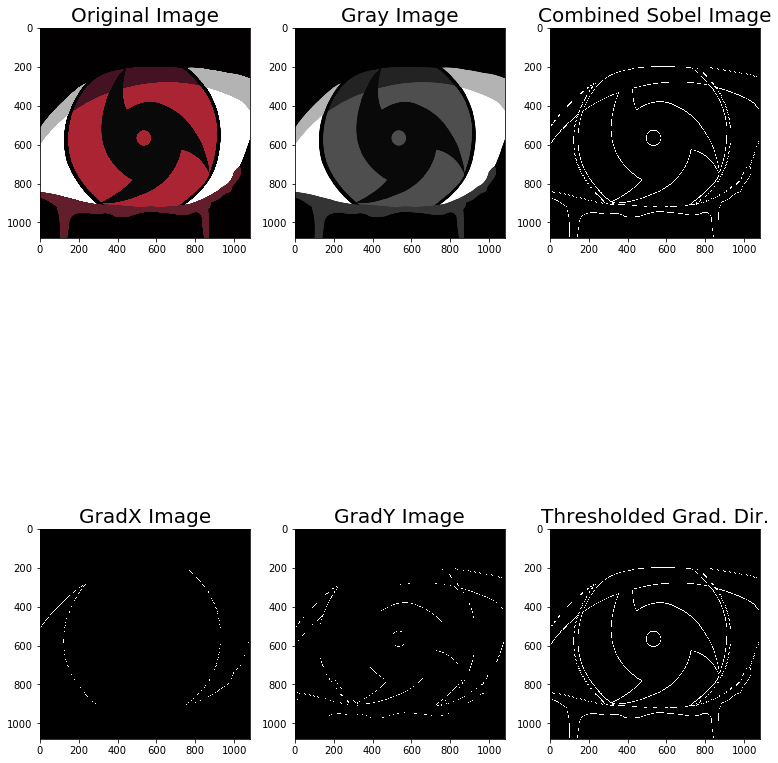

In [10]:
# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

In [11]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, kernel = 5)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

In [12]:
filter_output = 'Batman_Filter.mp4'
clip1 = VideoFileClip("Batman.mp4")
batman_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time batman_clip.write_videofile(filter_output, audio=False)

[MoviePy] >>>> Building video Batman_Filter.mp4
[MoviePy] Writing video Batman_Filter.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 265/265 [2:42:46<00:00, 36.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Batman_Filter.mp4 

Wall time: 2h 42min 47s


In [13]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))

In [ ]:
cap = cv2.VideoCapture(0)  # 0 for Python 3, 1 for Python 2. No idea why?!!

out = cv2.VideoWriter("output.avi", cv2.cv.CV_FOURCC('M','J','P','G'), 20,(640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,180)
        new_frame = process_image(frame)
        out.write(new_frame)

        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()